# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
import math
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
device

'cuda'

In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-20 16:35:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [            <=>     ] 201.24M  83.4MB/s    in 2.4s    

2023-10-20 16:35:49 (83.4 MB/s) - ‘data.txt.zip’ saved [211011981]



In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [7]:
set_random_seed(42)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

Предобработаем наши данные – масштабируем признаки (таргет не трогаем). Данная процедура необходима, чтобы улучшить сходимость алгоритмов градиентного спуска, привести линии уровня оптимизируемого функционала к "нормальному виду":

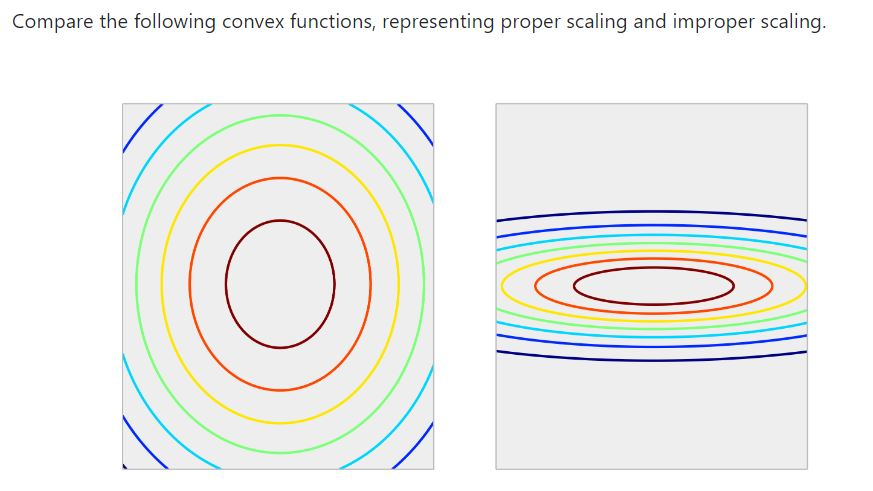

[Ссылка на источник картинки](https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re)

In [9]:
# масштабирование признаков

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [10]:
from sklearn.metrics import mean_squared_error

Теперь обучим Ridge-регрессию "из коробки":

In [ ]:
ridge = Ridge()
ridge.fit(X_train_sc, y_train)
rmse_for_ridge = np.round(mean_squared_error(y_test, ridge.predict(X_test_sc), squared=False), 4)
print(f"Ridge RMSE: {rmse_for_ridge}")

Ridge RMSE: 9.5102


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = np.round(mean_squared_error(y_test, np.full(y_test.shape[0], y_test.mean()), squared=False), 4)
print(f"Best RMSE for constant model: {best_rmse_metric}")

Best RMSE for constant model: 10.8519


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

---

В дальнейшем планирую работать с сущностью DataLoader из Pytorch, потому напишем небольшой класс, в котором будут реализованы все необходимые методы, такие как  *\_\_len\_\_* и *\_\_getitem\_\_*



In [ ]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

Создадим объекты нашего класса:

In [ ]:
train_dataset = MyDataset(X_train_sc, y_train)
test_dataset = MyDataset(X_test_sc, y_test)

Теперь можем обернуть их в DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=256)

Приступим к созданию модели c одним линейным слоем:

In [ ]:
class MichaelNet(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)

    def forward(self, X):
        return self.fc1(X)

In [ ]:
# Параметры модели

FEATURES = 90 # кол-во признаков
OUT_SIZE = 1 # выход нейронки, т.к. задача регрессии
NUM_EPOCH = 10 # кол-во эпох

model_Z = MichaelNet(FEATURES, OUT_SIZE).to(device)

In [ ]:
# реализация MSE
def loss_function(y_pred, y_true):
    return torch.mean(torch.square(y_pred - y_true))

Добавим функцию для визуализации изменения ошибки (MSE) и метрики (RMSE) в зависимости от эпохи (кажется это требуется по заданию)

Код частично взял с [2-го семинара Филиппа а.к.а. Лекции одного дата-шутера](https://www.youtube.com/watch?v=CKaBQx15mgw)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrcis, test_metrics):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')
    axs[0].set_title('MSE dynamic per epoch')

    axs[1].plot(range(1, len(train_metrcis) + 1), train_metrcis, label='train')
    axs[1].plot(range(1, len(test_metrics) + 1), test_metrics, label='test')
    axs[1].set_ylabel('metric')
    axs[1].set_title('RMSE dynamic per epoch')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

Теперь напишем код обучения и валидации модели:

In [ ]:
from tqdm.notebook import tqdm

'''
---------------------------------------------------------------
Дополнение к реализованному ниже алгоритму
обучения-валидации модели (в данном случае validation = test)
---------------------------------------------------------------
Немного поясню расчет MSE/RMSE на каждом из этапов.
Чуть выше написан код для loss_function (вычисление MSE).
Соответсвенно, обучаемся на данную ф.п и внутри каждой эпохи
идет расчет MSE батчей, но т.к. размер последнего батча может
отличаться от остальных осуществляется переход MSE -> SE,
что позволяет суммировать уже эти значения внутри эпох и после
делить на кол-во наблюдений всей выборки, а уже после брать
корень из получившегося числа, тем самым по-честному считая
метрику RMSE
---------------------------------------------------------------
'''

def train_model(model, train_loader, test_loadewr, lr):

    set_random_seed(42)
    train_losses, test_losses = [], [] # сюда будем закидывать MSE
    train_metrics, test_metrics = [], [] # тут RMSE

    for epoch in range(1, NUM_EPOCH + 1):

        train_loss = 0.0

        model.train() # режим обучения
        for batch in tqdm(train_loader, desc='Training'): # tqdm для красивых progress bar`ов
            x_train = batch['sample'].to(device) # переводим на активный ускоритель
            y_train = batch['target'].to(device)

            logits = model(x_train)
            loss = loss_function(logits, y_train)
            # обучаемся на MSE
            loss.backward()

            # делаем градиентный шаг
            model.fc1.weight = nn.Parameter(model.fc1.weight - lr*model.fc1.weight.grad)
            model.fc1.bias = nn.Parameter(model.fc1.bias - lr*model.fc1.bias.grad)
            model.fc1.zero_grad()

            train_loss += loss.detach().cpu().numpy() * len(x_train) # MSE -> SE

        lr = (lr/(1+epoch/2)) # уменьшаем шаг после каждой эпохи

        train_loss /= len(train_loader.dataset) # расчет MSE на эпохе
        train_losses.append(train_loss)
        train_metrics.append(math.sqrt(train_loss)) # расчет RMSE на эпохе

        val_loss = 0.0

        model.eval() # режим валидации
        for batch in tqdm(test_loader, desc='Validating'):
            x_test = batch['sample'].to(device)
            y_test = batch['target'].to(device)

            with torch.no_grad():
                logits = model(x_test)
                loss = loss_function(logits, y_test)

            val_loss += loss.detach().cpu().numpy() * len(x_test)

        val_loss /= len(test_loader.dataset)
        test_losses.append(val_loss)
        test_metrics.append(math.sqrt(val_loss))

        plot_losses(train_losses, test_losses, train_metrics, test_metrics)

    # выведем результат RMSE на тесте
    num = [e for e in range(1, NUM_EPOCH + 1)]
    test_metrics = [round(elem, 3) for elem in test_metrics]
    dataset_error = pd.DataFrame({'epoch': num, 'RMSE test': test_metrics})
    print('------------------')
    print(dataset_error.set_index('epoch'))


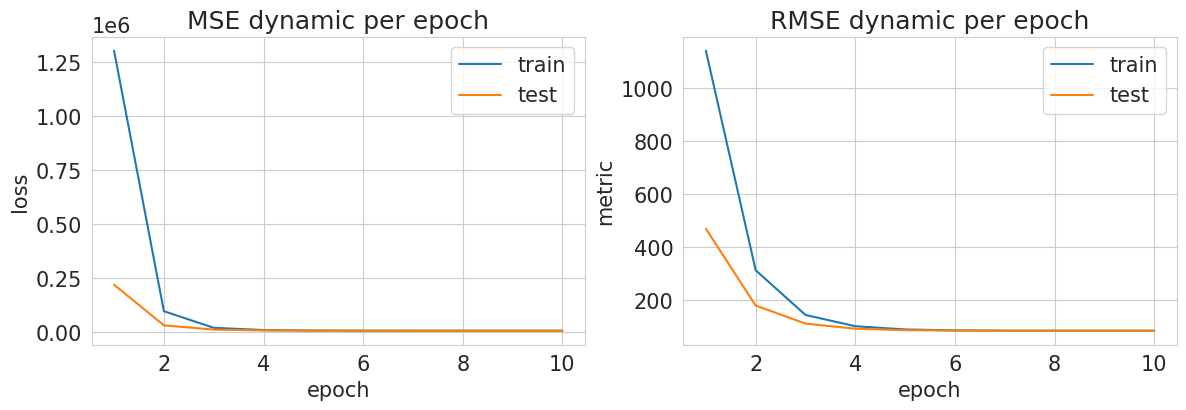

------------------
       RMSE test
epoch           
1        468.970
2        178.689
3        110.566
4         91.356
5         85.750
6         84.214
7         83.776
8         83.776
9         83.776
10        83.776


In [ ]:
train_model(model_Z, train_loader, test_loader, lr=0.0004)

---

Комментарий:

Можно заметить, что ошибка перманентно убывает от 1-й до 5-й эпохи, и достигнув определенных значений практически перестает падать. Если немного увеличить шаг, то получится снизить ошибку, достичь значения метрики в ~ 10 единиц, но в таком случае RMSE на первых эпохах будет убывать слишком стремительно и график уже не будет столь красивым :D



---

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

---

Отскейлим значения целевой переменной, как указано в подсказке:

In [12]:
scaler_y = StandardScaler()

y_train_sc = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.reshape(-1, 1))

Создадим пару новых datasets, так как прошлые не годятся – там не отмасштабированный таргет. На этот раз не будем создавать класс *DataSet* вручную, а воспользуемся уже готовым решением из *torch.utils.data*:

In [55]:
train_set = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train_sc).to(torch.float), torch.from_numpy(y_train_sc).to(torch.float)
)

test_set = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test_sc).to(torch.float), torch.from_numpy(y_test_sc).to(torch.float)
)

Теперь закинем всё это дело в DataLoader:

In [84]:
set_random_seed(64)
train_loader_2 = DataLoader(train_set, shuffle=True, batch_size=64)
test_loader_2 = DataLoader(test_set, shuffle=False, batch_size=64)

In [85]:
FEATURES = 90 # кол-во признаков
OUT_SIZE = 1 # выход нейронки, т.к. задача регрессии

Слепим модельку, немного разнообразив архитектуру (закоменчено всё по делу):

In [198]:
class ez3nXNet10(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.Dropout(0.2),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.Dropout(0.1),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(16, 1),
            # nn.Dropout(0.2),
            # nn.BatchNorm1d(64),
            # nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.Dropout(0.3),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Linear(32, 1)
            )
        set_random_seed(42)

    def forward(self, X):
       return self.model(X)

Оставил на всякий случай запасной вариант

In [231]:
# model_Y = ez3nXNet10(90).to(device)

# def initialize_weights(m):
#     if hasattr(m, 'weight') and m.weight.dim() > 1:
#         nn.init.xavier_uniform_(m.weight.data)

# model_Y.apply(initialize_weights)

# set_random_seed(32)

# #optimizer = torch.optim.Adam(model_Y.parameters(), lr=0.003, weight_decay=0.001)
# optimizer = torch.optim.SGD(model_Y.parameters(), lr=0.0122, momentum=0.75, weight_decay=0.0007)
# lambda1 = lambda epoch: 0.99 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
# criterion = nn.MSELoss()
# # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)


Тут необходимо пояснение:

Выбор архитектуры нейронной сети – занятие довольно занимательное и интересное. Пришлось почитать многое и прилично поэксперемнтировать (подробнее об этом в отчете)  
Здесь же раскрою теоретические моменты:


####**BatchNorm1d**  
Мы уже говорили, что для линейных моделей важно нормировать признаки перед подачей на вход. Но возможно ли нормировать их еще и на выходах внутренних слоев? Как раз в этом нам и поможет BatchNorm (есть также LayerNorm, InstanceNorm).

Если коротко, то BatchNorm для каждого признака вычитает среднее значение по батчу и делит на стандартное отклонение по батчу, потом домножает все признаки на вес $\gamma$ и прибавляет вес $\beta$.

BatchNorm работает по разному во время обучения и предсказний:

**Во время обучения**. Пусть батч состоит из $\mathbf{x_i}$ (каждый $\mathbf{x_i}$ - вектор, подающийся на вход). Тогда
$$\begin{aligned}
\mu_{\mathcal{B}} & \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_{i} \\
\sigma_{\mathcal{B}}^{2} & \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{\mathcal{B}}\right)^{2} \\
\widehat{x}_{i} & \leftarrow \frac{x_{i}-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}} \\
y_{i} & \leftarrow \gamma \widehat{x}_{i}+\beta \equiv \mathrm{B} \mathrm{N}_{\gamma, \beta}\left(x_{i}\right)
\end{aligned}$$

**Во время предсказания**. Мы делаем то же самое, но у нас нет батча. Поэтому в качестве $\mu_{\mathcal{B}}$ и $\sigma_{\mathcal{B}}$ мы используем среднее и стандартное отклонение признака во всем датасете. Обычно нам не хочется после обучения еще раз применять сеть ко всем примерам из обучающего датасета, чтобы вычислить эти статистики и мы вместо них используем **экспоненциально затухающее среднее последних батчей.**






### Что это дает?

* Более быстрое обучение. Большие learning_rate"ы
* Обучение более глубоких сетей
* Регуляризация
* Повышение точности моделей

#### **Dropout**

Дропаут это еще один необычный слой, который используется в нейронных сетях. У него есть один гиперпараметр $p$.

Идея дропаута состоит в том, что во время обучения мы зануляем случайную часть входа и отдаем вход дальше (для каждого числа мы подбрасываем монетку и с вероятностью $p$ зануляем это число).

Дропаут позволяет тренировать более устойчивые сети и избегать переобучения.

Как мы сказали выше, dropout зануляет случайную часть входов и отдает их дальше. Допустим $p=0.5$ (достаточное популярное значение). Тогда мы просто убираем половину всего входа! Такое сильное воздействие явно плохо повлияет на качество нашей модели, поэтому мы делаем зануление только во время обучения.

**Во время обучения**: для каждого числа во входе подбрасываем монетку и зануляем его с вероятностью $p$. Выход умножаем на $\frac{1}{1-p}$, чтобы дисперсия выходов осталось такой же, как и на входе.

**Во время предсказаний**: ничего не делаем).

### Что дает?

* Сеть выучивает более устойчивые представления на внутренних слоях.
* Сильно увеличивает число итераций, которые нужны для сходимости.
* Можно получить интерпретацию, которая говорит, что дропаут усредняет выходы большо числа нейросетей с $p|W|$ нейронами на предыдущем слоев.

Дропаут вызывает интересный эффект: в начале обучения качество на тестовом датасете выше, чем на обучающем. Потому что для обучающего датасета у нас есть зануление, которое сильно портит предсказания.

Код обучения - валидации (похож на то, что было в 1-м задании за исключением расчета ошибки)

In [249]:
def train_val(model, optimizer, criterion, train_loader, test_loader, scheduler=None):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """

    test_rmse = []
    train_rmse = []
    for epoch in range(1, 11):


        model.train()
        set_random_seed(64)
        for x_tr, y_tr in tqdm(train_loader, desc='Training'):

            x_tr = x_tr.to(device)
            y_tr = y_tr.to(device)

            logits = model(x_tr)
            loss = criterion(y_tr, logits)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        train_rmse_real = mean_squared_error(
        scaler_y.inverse_transform(model(torch.FloatTensor(X_train_sc).to(device)).cpu().detach().numpy()),
        scaler_y.inverse_transform(y_train_sc), squared = False)
        print(f'Ошибка на трейне после {epoch} эпохи {train_rmse_real}')
        train_rmse.append(train_rmse_real)

        model.eval()
        set_random_seed(64)
        test_rmse_real = mean_squared_error(
        scaler_y.inverse_transform(model(torch.FloatTensor(X_test_sc).to(device)).cpu().detach().numpy()),
        scaler_y.inverse_transform(y_test_sc), squared = False)
        print(f'Ошибка на тесте после {epoch} эпохи {test_rmse_real}')
        test_rmse.append(test_rmse_real)

        if scheduler:
            scheduler.step()

    return train_rmse, test_rmse

In [250]:
model_Y = ez3nXNet10(90).to(device)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model_Y.apply(initialize_weights)

set_random_seed(32)

optimizer = torch.optim.Adam(model_Y.parameters(), lr=0.00026, weight_decay=0.0011)
# optimizer = torch.optim.SGD(model_Y.parameters(), lr=0.0122, momentum=0.75, weight_decay=0.0007)
lambda1 = lambda epoch: 0.99 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.945)


In [251]:
train_rmse, test_rmse = train_val(model_Y, optimizer, criterion,
                                    train_loader_2, test_loader_2, scheduler)

Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 1 эпохи 9.018939657673593
Ошибка на тесте после 1 эпохи 8.92125136978895


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 2 эпохи 8.852965759216373
Ошибка на тесте после 2 эпохи 8.83841534827344


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 3 эпохи 8.781197125393295
Ошибка на тесте после 3 эпохи 8.806501622446635


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 4 эпохи 8.737076322524155
Ошибка на тесте после 4 эпохи 8.789336791630468


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 5 эпохи 8.705004809816272
Ошибка на тесте после 5 эпохи 8.776472139303623


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 6 эпохи 8.684058449999817
Ошибка на тесте после 6 эпохи 8.7666600463354


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 7 эпохи 8.668807796377376
Ошибка на тесте после 7 эпохи 8.762259516858968


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 8 эпохи 8.652189036298417
Ошибка на тесте после 8 эпохи 8.75799361636509


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 9 эпохи 8.638837497585559
Ошибка на тесте после 9 эпохи 8.758586425692041


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

Ошибка на трейне после 10 эпохи 8.627936555270704
Ошибка на тесте после 10 эпохи 8.760012395064136


In [252]:
def plot_(train_losses, test_losses):
    clear_output()
    fig, axs = plt.subplots(1, 1, figsize=(9, 5))
    axs.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs.plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs.set_ylabel('loss')
    axs.set_xlabel('epoch')
    axs.legend()
    plt.title('RMSE dynamic per epoch')
    plt.show()

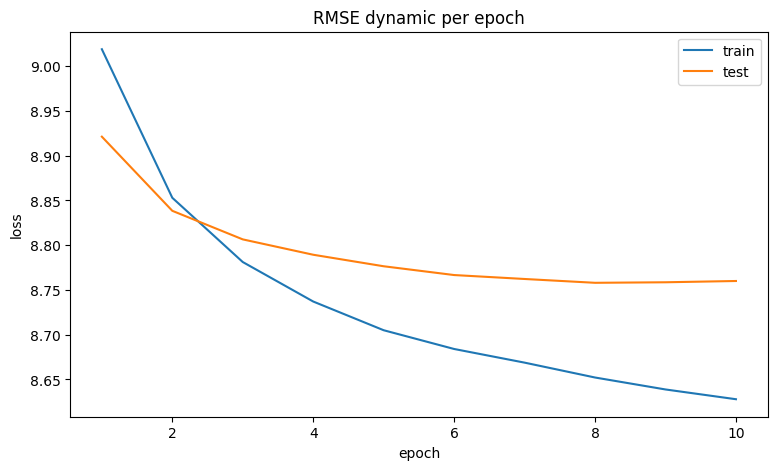

In [253]:
plot_(train_rmse, test_rmse)

не хватило буквально чуть-чуть, а счастье было тк близко...

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

---

Было опробовано порядка 40 архитектур. Некоторые из них показали весьма приличное качество - ниже 8.75.



Так, например, следующая модель на 8-й эпохе выбила метрику RMSE на тесте 8.72. Но к сожалению, сид зафиксирован не был и повторно того же результата достичь с ней не получилось.



```
class ez3nXNet4(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
            )

    def forward(self, X):
       return self.model(X)


model_v9 = ez3nXNet4(FEATURES)
optimizer9 = torch.optim.SGD(model_v9.parameters(), lr=0.1, momentum=0.9)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler9 = torch.optim.lr_scheduler.LambdaLR(optimizer9, lr_lambda=lambda1)
criterion = nn.MSELoss()
```



Здесь я решил сделать достаточно широкую нейросеть - увеличил число нейронов на выходе первого слоя и последовательно уменьшал их кол-во. Функция активации была выбрана LeakyRElu. Были задействованы батчнормы, принципы которых уже ранее расписывал. Практически в самом конце архитектуры сети был добавлен Dropout. Стохастический градиентный спуск + моментум и шедулер, замедляющий шаг от эпохи к эпохе.
В качестве док-ва работоспособности могу привести сохранившиеся результаты:


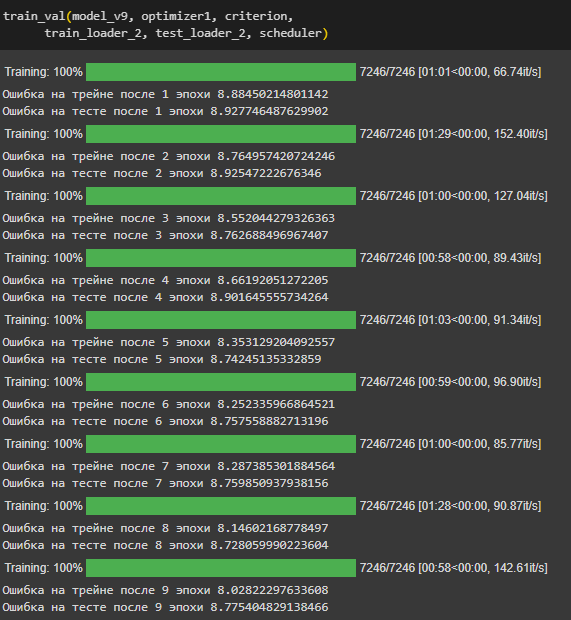

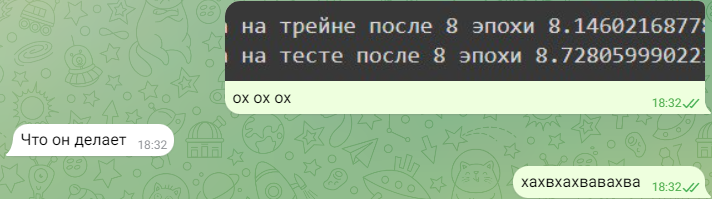

---

Аналогичная участь постигла следующую модель. Здесь сид уже был зафиксирован, но как оказалось, не в каждой из нужных ячеек, что вновь не обеспечило воспроизводимость результата, который составил 8.74 на тесте!



```
class ez3nXNet7(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
            )
        set_random_seed(64)

    def forward(self, X):
       return self.model(X)

model_v7 = ez3nXNet7(FEATURES)
optimizer7 = torch.optim.SGD(model_v7.parameters(), lr=0.1, momentum=0.9)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler7 = torch.optim.lr_scheduler.LambdaLR(optimizer7, lr_lambda=lambda1)
criterion = nn.MSELoss()
```



Качественно архитектура сети здесь не менялась - я убавил лишь кол-во нейронов на внутренних слоях, что несколько позволило ускорить процесс обучения + снижена вероятность зануления нейронов на выходе предыдущего слоя в Dropout

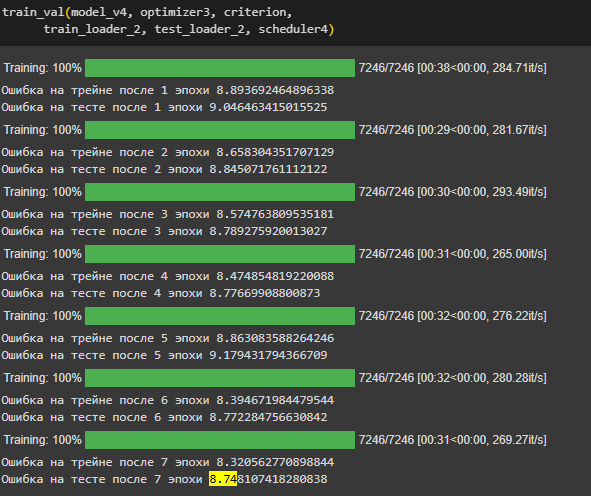

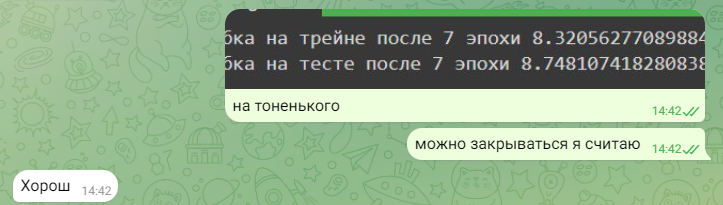

Здорово, когда всё зафиксировано)

---

В ряде других экспериментов использовал Adam вместо SGD, так как на тот момент думал, что только там есть параметр weight_decay
Но почему-то с ним значимых результатов добиться не удалось, хотя были относительно успешные тесты, которые достигали отметки в 8.76

Где-то, как здесь например, пробовал поменять шедулер - менять шаг иначе  
На [Kaggle](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling#5.-ExponentialLR) нашел хорошую статью по разным вариантам шедулеров и тоже эксперементировал с ними.



```
class ez3nXNet10(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(90, 220),
            nn.LeakyReLU(),
            nn.BatchNorm1d(220),
            nn.Linear(220, 110),
            nn.LeakyReLU(),
            nn.BatchNorm1d(110),
            nn.Linear(110, 60),
            nn.LeakyReLU(),
            nn.BatchNorm1d(60),
            nn.Dropout(0.2),
            nn.Linear(60, 1),
            )

    def forward(self, X):
       return self.model(X)

model_54 = ez3nXNet10(90)

GAMMA = 0.99

optimizer = torch.optim.AdamW(model_54.parameters(), lr = 0.01)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)
```



Но данная модель послужила прекрасным примером *overfitting* - ошибка на трейне падала, а на тесте - предательски возрастала.
Здесь использовал более простую нейронку, но другой градиентный метод и шедулер соответственно.

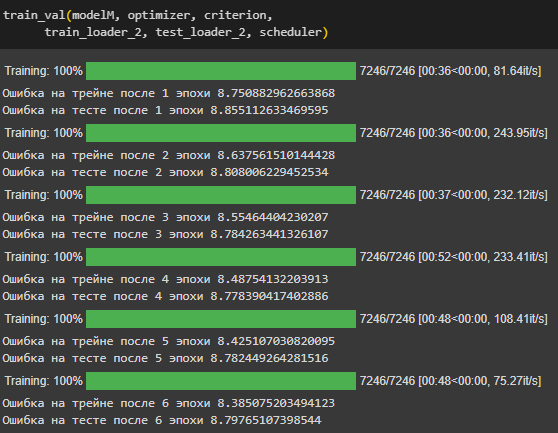

Дополнительно эксперементировал с batch_size. На лекции говорили, что это также может сказываться на обучении. В целом, заметил, что при увеличении только лишь batch_size без изменений длины шага ошибка прилично возрастала в моем случае.

---

Также открыл для себя отличный настраиваемый параметр - WEIGHT_DECAY (аналог L2 регуляризации), который изначально не очень зарекомендовал себя в моих моделях. Но в дальнейшем, грамотно подобрав нужные значения, заметил, что обучение стало более стабильным: ошибка на трейне перестала с фантастической скоростью падать.
Более того был очень обрадован, что WEIGHT_DECAY присутствует не только в имлементации Adam`а, но и в SGD (НО: в PyTorch данный параметр накладывает регуляризацию на все параметры модели - и на баес тоже, что не очень может быть и хорошо)



```
class ez3nXNet10(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(16, 1),
            )
        set_random_seed(42)

    def forward(self, X):
       return self.model(X)

model_Y = ez3nXNet10(90).to(device)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model_Y.apply(initialize_weights)

set_random_seed(32)

optimizer = torch.optim.SGD(model_Y.parameters(), lr=0.0122, momentum=0.75, weight_decay=0.0007)
lambda1 = lambda epoch: 0.99 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
criterion = nn.MSELoss()

```



Во-первых, здесь я избавился от BatchNorm`ов, решил просто поэксперементировать с этим. Более того, я отошел от рандомный инициализации начальных весов - выбрал [Xavier Initialization](https://paperswithcode.com/method/xavier-initialization) + [тут тоже можно почитать](https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/)

Но справделивости ради это мне подсказали коллеги по работе)

Всё в совокупности позволило перейти к более плавному изменению целевой метрики - RMSE на трейне и тесте более не скакала, а постепенно снижалась в сотых-тысячных долях от эпохи к эпохе. Но все равно заветную отметку в 8.75 преодолеть не удалось.

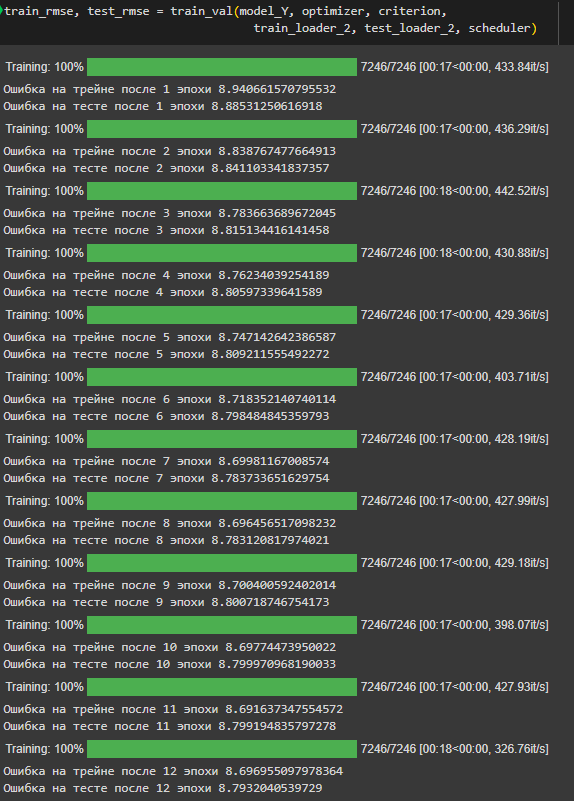

---

Вывод: